1.. Find the census trck shape files online (American Fact Finder has them), http://www1.nyc.gov/ has them. The folder you should download is names nycb2010_16d. 
Load it as a geopandas file

In [1]:
import geopandas as gpd
import os
from fiona.crs import from_epsg
import shapely.geometry
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page

In [3]:
url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip'

In [4]:
os.system('wget ' + url)
os.system("mv " + 'nycb2010_16d.zip ' + os.getenv("PUIDATA"))
os.system('unzip ' + os.getenv("PUIDATA") + "/" + "nycb2010_16d.zip " + \
'-d ' +  os.getenv("PUIDATA"))


0

In [ ]:
#tracks
#os.system('wget ' + url)
#os.system("mv " + 'nyct2010_16d.zip ' + os.getenv("PUIDATA"))
#os.system('unzip ' + os.getenv("PUIDATA") + "/" + "nyct2010_16d.zip " + \
#'-d ' +  os.getenv("PUIDATA"))

In [5]:
#blocks
ct_shape = gpd.read_file(os.getenv("PUIDATA") + "/nycb2010_16d/nycb2010.shp" )

In [236]:
#tracks
#ct_shape = gpd.read_file(os.getenv("PUIDATA") + "/nyct2010_16d/nyct2010.shp" )

In [6]:
# a view of the shape file loaded as a geojson file will look like this. Notice the coordinates. They are in 
# epsg=2263 is US feet. You want to convert them in epsg=4326: lat/on . 
# Look at the notebook https://github.com/fedhere/PUI2016_fb55/blob/master/Lab9_SRK325/GeospatialAnalysis_CitiBike.ipynb
print ct_shape.shape
ct_shape.head()


(38794, 8)


,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,"POLYGON ((962269.1260375977 173705.5001831055,..."
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,"POLYGON ((964642.2676391602 161835.2651977539,..."
2,50027001000,5,Staten Island,1000,002700,150406.766022,1703.381172,"POLYGON ((963363.1168212891 167356.3336181641,..."
3,50040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,"POLYGON ((960069.9965820312 161953.6936035156,..."
4,50064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,"POLYGON ((963023.891784668 158246.7521972656, ..."


2.. Extract only the Brooklyn shape polygons and convert the coordinates to lat/lon 

In [10]:
#change the projection system
ct_brk = ct_shape.copy().loc[ct_shape.BoroName == 'Brooklyn',]
ct_brk.crs = from_epsg(2263)
#ct_brk = ct_brk.to_crs(coordinate)
ct_brk.to_crs(epsg=4326, inplace=True)
ct_brk.head()


,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
5037,30002001000,3,Brooklyn,1000,000200,208484.989566,2097.493132,POLYGON ((-74.00659158337982 40.65561273365177...
5038,30003011000,3,Brooklyn,1000,000301,63365.958361,1006.913933,POLYGON ((-73.99514512602698 40.69877384567195...
5039,30005011000,3,Brooklyn,1000,000501,116303.194723,1431.900698,POLYGON ((-73.99270830309769 40.69809925981344...
5040,30011001000,3,Brooklyn,1000,001100,54802.306859,951.657541,POLYGON ((-73.98514306089652 40.69488514296981...
5041,30015001000,3,Brooklyn,1000,001500,79196.530872,1129.348482,POLYGON ((-73.98305147125492 40.69837793354038...


In [221]:
#ct_brk.loc[35383]

3.. Find the coordinates of CUSP: 1 MetroTech Brooklyn. Create a Point shapely geometry with the coordinates of CUSP

    shapely.geometry.Point()

In [11]:
geolocator = Nominatim()
cuspLocation = geolocator.geocode("1 MetroTech Center, Brooklyn, Nueva York")

cuspPoint = shapely.geometry.Point(cuspLocation.longitude,cuspLocation.latitude)
#cuspPoint = shapely.geometry.Point(-73.9868223,40.692822)
#print(cuspPoint)
print(cuspPoint)

POINT (-73.98671759998339 40.69323015)


4.. Loop over the Brookly polygons (nearly 10000) and assess find in which geometry the polygon is contained

In [12]:
ct_brk.geometry.contains(cuspPoint).sum()

1

In [14]:
ct_brk['cusp']= ct_brk.geometry.contains(cuspPoint)
ct_brk[ct_brk.cusp]

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry,cusp
35383,30011001009,3,Brooklyn,1009,001100,69934.269433,1061.280668,"POLYGON ((-73.98619262163143 40.693753518938, ...",True


5.. Plot one every 10 polygons of brooklyn (using the geopandas datafame method plot)
and overplot the locati`on of cusp as a point (using pylab.scatter)
Overplot also the census track that contains cusp in red (using the geopandas datafame method plot)

In [16]:
ct_brk.shape[0]

9682

In [17]:
ct_brk['forPlot'] = [i%10 == 0 for i in range(ct_brk.shape[0])]

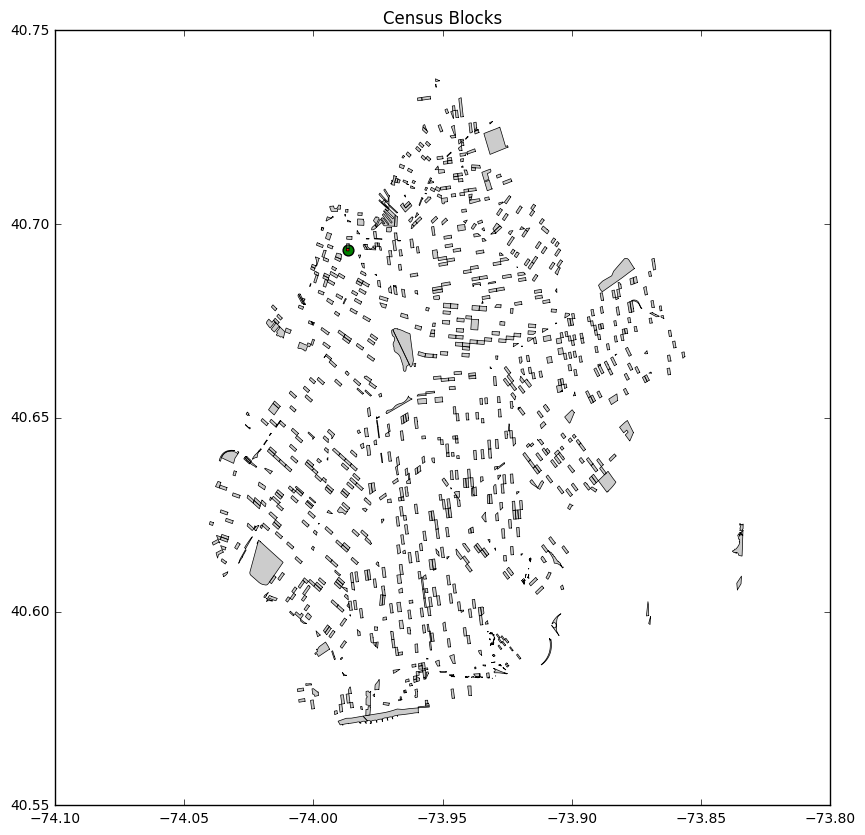

In [23]:
f, ax = plt.subplots(figsize=(10,10))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)

ct_brk[ct_brk.cusp].plot(color = 'red', alpha=1,linewidth=0.5,ax=ax)
#ct_brk.plot(color = 'gray', alpha=.40,linewidth=0.5,ax=ax)
ct_brk[ct_brk.forPlot].plot(color = 'gray', alpha=.40,linewidth=0.5,ax=ax)
ax.scatter(cuspPoint.x,cuspPoint.y,c='green',s=60)
plt.title("Census Blocks")

## Figure 1
Map of selected Brooklyn census blocks, with the block containing 1 Metrotech Center marked in red.